In [74]:
from pathlib import Path
from datasets import load_from_disk, concatenate_datasets
import pandas as pd
import numpy as np
from datasets import load_from_disk

In [75]:
def find_dataset_path(folder: Path) -> Path:
    for sub in folder.rglob("dataset_info.json"):
        return sub.parent
    raise FileNotFoundError(f"No dataset found inside {folder}")

In [76]:
extracted_path = Path("F:/amazon_extracted_temp")
save_path = Path("F:/BigDataA3/cleaned_parquets")
save_path.mkdir(parents=True, exist_ok=True)

# 2. Data Cleaning and Preprocessing

Distribution of ratings and relationship between review length and rating was derived using Pearson correlation.

In [77]:
for review_folder in extracted_path.glob("raw_review_*"):
    category = review_folder.name.replace("raw_review_", "")
    meta_folder = extracted_path / f"raw_meta_{category}"
    output_file = save_path / f"{category}.parquet"

    # Skip if already processed
    if output_file.exists():
        print(f"Skipping {category} ")
        continue

    try:
        print(f"\nProcessing {category}...")

        # Sample 20%
        review_ds = load_from_disk(find_dataset_path(review_folder))
        meta_ds = load_from_disk(find_dataset_path(meta_folder))

        review_sample = review_ds.shuffle(seed=42).select(range(int(0.2 * len(review_ds))))
        meta_sample = meta_ds.shuffle(seed=42).select(range(int(0.2 * len(meta_ds))))

        review_df = review_sample.to_pandas()
        meta_df = meta_sample.to_pandas()

        # Merge and filter
        merged = pd.merge(review_df, meta_df, on="parent_asin", how="inner", suffixes=("_review", "_meta"))
        merged = merged[merged["rating"].between(1, 5)]
        merged = merged[merged["text"].str.strip().astype(bool)]

        if "details" in merged.columns:
            merged["brand"] = merged["details"].apply(lambda d: d.get("brand") if isinstance(d, dict) else None)
        else:
            merged["brand"] = None

        merged["brand"] = merged["brand"].fillna(merged.get("store", np.nan)).fillna("Unknown")
        merged = merged.drop_duplicates(subset=["user_id", "asin", "text"])
        merged["review_length"] = merged["text"].str.split().apply(len)

        if "timestamp" in merged.columns:
            merged["year"] = pd.to_datetime(merged["timestamp"], unit="s", errors="coerce").dt.year

        # Keep essential columns
        essential_cols = [
            "user_id", "asin", "rating", "text", "verified_purchase", "helpful_vote",
            "brand", "main_category", "review_length", "year"
        ]
        cleaned = merged[essential_cols]

        # Save
        cleaned.to_parquet(output_file, index=False)
        print(f"Saved: {output_file.name} — {cleaned.shape[0]} rows")

    except Exception as e:
        print(f"Error in {category}: {e}")

Skipping All_Beauty 
Skipping Amazon_Fashion 
Skipping Appliances 
Skipping Arts_Crafts_and_Sewing 
Skipping Automotive 
Skipping Baby_Products 
Skipping Beauty_and_Personal_Care 
Skipping Books 
Skipping CDs_and_Vinyl 
Skipping Cell_Phones_and_Accessories 
Skipping Clothing_Shoes_and_Jewelry 
Skipping Digital_Music 
Skipping Electronics 
Skipping Gift_Cards 
Skipping Grocery_and_Gourmet_Food 
Skipping Handmade_Products 
Skipping Health_and_Household 
Skipping Health_and_Personal_Care 
Skipping Home_and_Kitchen 
Skipping Industrial_and_Scientific 
Skipping Kindle_Store 
Skipping Magazine_Subscriptions 
Skipping Movies_and_TV 
Skipping Musical_Instruments 
Skipping Office_Products 
Skipping Patio_Lawn_and_Garden 
Skipping Pet_Supplies 
Skipping Software 
Skipping Sports_and_Outdoors 
Skipping Subscription_Boxes 
Skipping Tools_and_Home_Improvement 
Skipping Toys_and_Games 
Skipping Unknown 
Skipping Video_Games 


Cleaned parquet files were placed into a single Dataframe

In [78]:
data_dir = Path("F:/BigDataA3/cleaned_parquets")

In [79]:
categories = [
    "All_Beauty", "Amazon_Fashion", "Appliances", "Arts_Crafts_and_Sewing"
]
files = [data_dir / f"{cat}.parquet" for cat in categories]

In [80]:
# Read and concatenate
dfs = [pd.read_parquet(f) for f in files]
final_dataset = pd.concat(dfs, ignore_index=True)
print("Final dataset shape:", final_dataset.shape)

Final dataset shape: (14130466, 10)


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns


# 3. Exploratory Data Analysis (EDA)

### Histogram of star ratings

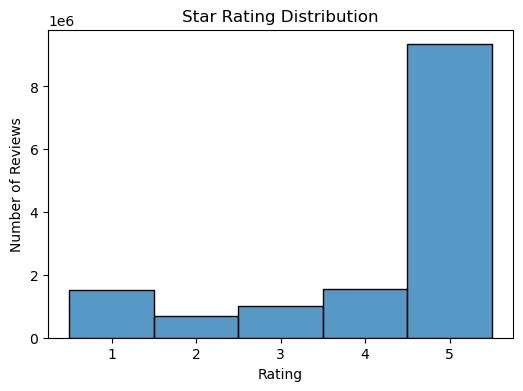

In [82]:
# 1. Histogram of star ratings
plt.figure(figsize=(6, 4))
sns.histplot(final_dataset["rating"], bins=[1, 2, 3, 4, 5, 6], discrete=True)
plt.title("Star Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.show()

### Top 10 main categories

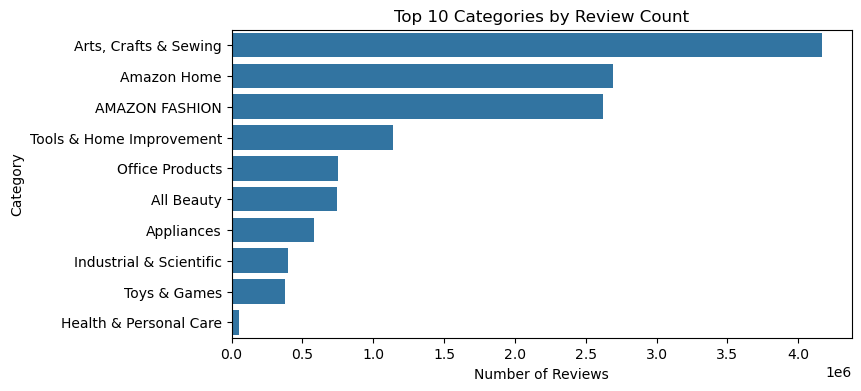

In [83]:
# 2. Top 10 main categories
top_categories = final_dataset["main_category"].value_counts().nlargest(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top 10 Categories by Review Count")
plt.xlabel("Number of Reviews")
plt.ylabel("Category")
plt.show()

### Top 10 brands excluding "Unknown"

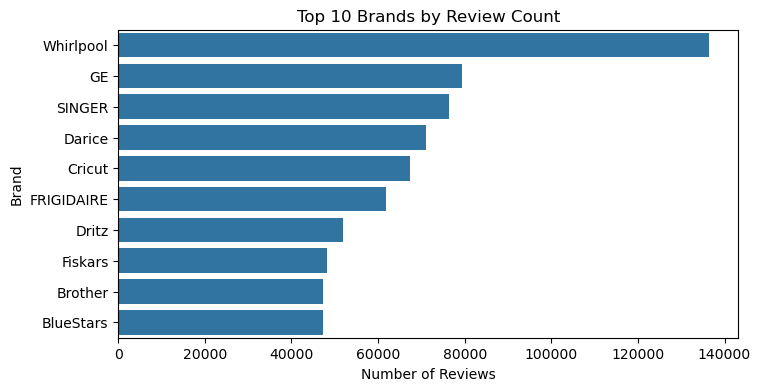

In [84]:
# 3. Top 10 brands (excluding 'Unknown')
top_brands = final_dataset[final_dataset["brand"] != "Unknown"]["brand"].value_counts().nlargest(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.title("Top 10 Brands by Review Count")
plt.xlabel("Number of Reviews")
plt.ylabel("Brand")
plt.show()

### Line chart of average rating per year

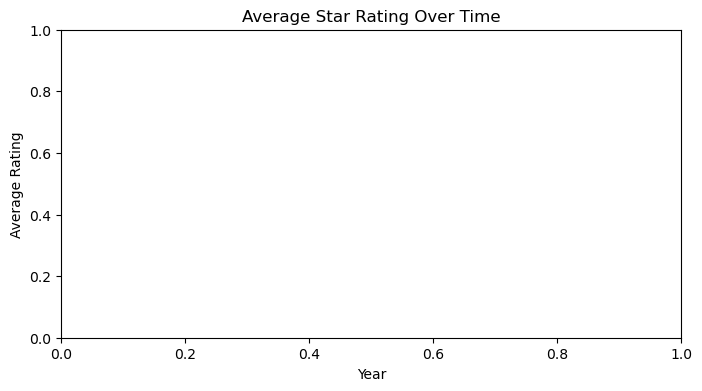

In [85]:
# 4. Line chart: average rating per year
yearly_avg = final_dataset.dropna(subset=["year"]).groupby("year")["rating"].mean()
plt.figure(figsize=(8, 4))
sns.lineplot(x=yearly_avg.index, y=yearly_avg.values)
plt.title("Average Star Rating Over Time")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.show()


### Correlation between review_length and rating

In [86]:
# 5. Correlation: review_length vs. rating
correlation = final_dataset["review_length"].corr(final_dataset["rating"])
print(f"Pearson correlation between review length and rating: {correlation:.4f}")

Pearson correlation between review length and rating: -0.1099


# 4. Binary Sentiment Prediction (Logistic Regression)

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [88]:
# 1. Convert rating to binary sentiment label
final_dataset["sentiment"] = (final_dataset["rating"] > 3).astype(int)

In [89]:
# 2. Train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    final_dataset["text"],
    final_dataset["sentiment"],
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [90]:
# 3. TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    lowercase=True,
    token_pattern=r"(?u)\b\w+\b",
    min_df=5,  
    max_df=0.8  
)

X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [91]:
# 4. Train Logistic Regression Classifier
clf = LogisticRegression()
clf.fit(X_train, train_labels)

e:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [92]:
# 5. Predict and Evaluate
predictions = clf.predict(X_test)

accuracy = accuracy_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
cm = confusion_matrix(test_labels, predictions)

In [93]:
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9095
F1 Score: 0.9421


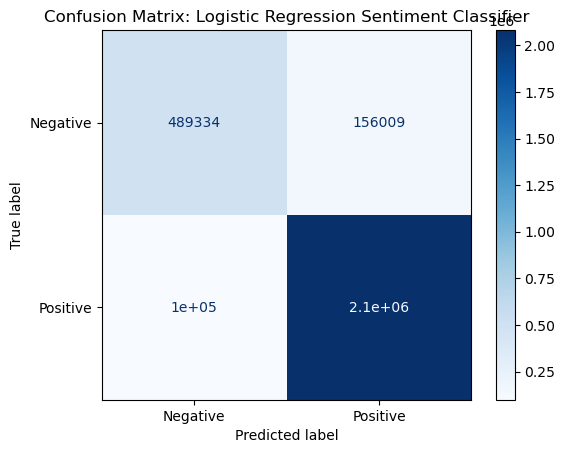

In [94]:
# 6. Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: Logistic Regression Sentiment Classifier")
plt.show()

# 5. Recommender System (ALS)

In [95]:
import os
import sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [96]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ALS Recommendation").getOrCreate()

In [97]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col

In [98]:
raw_sample = final_dataset[["user_id", "asin", "rating"]].dropna()

In [99]:
# Filter users with at least 5 reviews
user_counts = raw_sample["user_id"].value_counts()
eligible_users = user_counts[user_counts >= 5].index
filtered_users = raw_sample[raw_sample["user_id"].isin(eligible_users)]

In [100]:
# Sample up to 20k rows
filtered_sample = filtered_items.sample(n=min(20000, len(filtered_items)), random_state=42)
print("Filtered sample shape:", filtered_sample.shape)

Filtered sample shape: (20000, 3)


In [101]:
# Encode user and item IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
filtered_sample["user_idx"] = user_encoder.fit_transform(filtered_sample["user_id"])
filtered_sample["item_idx"] = item_encoder.fit_transform(filtered_sample["asin"])


In [102]:
# Create Spark DataFrame
ratings_spark = spark.createDataFrame(filtered_sample[["user_idx", "item_idx", "rating"]])
ratings_spark = ratings_spark.withColumn("rating", col("rating").cast(FloatType()))

In [103]:
train_data, test_data = ratings_spark.randomSplit([0.8, 0.2], seed=42)

In [104]:
#print("Train count:", train_data.count(), "Test count:", test_data.count())

In [105]:
from pyspark.ml.recommendation import ALS

als = ALS(
    userCol="user_idx",
    itemCol="item_idx",
    ratingCol="rating",
    nonnegative=True,
    coldStartStrategy="drop",
    maxIter=10,
    rank=10,
    regParam=0.1
)

model = als.fit(train_data)
print("ALS model trained successfully.")

Py4JJavaError: An error occurred while calling o509.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 4.0 failed 1 times, most recent failure: Lost task 0.0 in stage 4.0 (TID 9) (Brandons-PC executor driver): java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:328)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:355)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:808)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:381)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$SliceIterator.hasNext(Iterator.scala:268)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at scala.collection.AbstractIterator.to(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$take$2(RDD.scala:1492)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.rdd.RDD.$anonfun$take$1(RDD.scala:1492)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1465)
	at org.apache.spark.rdd.RDD.$anonfun$isEmpty$1(RDD.scala:1602)
	at scala.runtime.java8.JFunction0$mcZ$sp.apply(JFunction0$mcZ$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.isEmpty(RDD.scala:1602)
	at org.apache.spark.ml.recommendation.ALS$.train(ALS.scala:975)
	at org.apache.spark.ml.recommendation.ALS.$anonfun$fit$1(ALS.scala:737)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.recommendation.ALS.fit(ALS.scala:714)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: java.net.SocketException: Connection reset
	at java.base/sun.nio.ch.NioSocketImpl.implRead(NioSocketImpl.java:328)
	at java.base/sun.nio.ch.NioSocketImpl.read(NioSocketImpl.java:355)
	at java.base/sun.nio.ch.NioSocketImpl$1.read(NioSocketImpl.java:808)
	at java.base/java.net.Socket$SocketInputStream.read(Socket.java:966)
	at java.base/java.io.BufferedInputStream.fill(BufferedInputStream.java:244)
	at java.base/java.io.BufferedInputStream.read(BufferedInputStream.java:263)
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:381)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$SliceIterator.hasNext(Iterator.scala:268)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at scala.collection.AbstractIterator.to(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1431)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$take$2(RDD.scala:1492)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2433)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


# 6. Clustering / Segmentation (k-means)

In [106]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

product_stats = final_dataset.groupby("asin").agg({
    "rating": "mean",
    "user_id": "count",
    "brand": "first",
    "main_category": "first"
}).rename(columns={
    "rating": "mean_rating",
    "user_id": "total_reviews"
}).reset_index()

brand_encoder = LabelEncoder()
cat_encoder = LabelEncoder()
product_stats["brand_id"] = brand_encoder.fit_transform(product_stats["brand"])
product_stats["category_id"] = cat_encoder.fit_transform(product_stats["main_category"])

# Drop any NaNs
product_stats = product_stats.dropna(subset=["mean_rating", "total_reviews", "brand_id", "category_id"])


In [107]:
from sklearn.cluster import KMeans

X = product_stats[["mean_rating", "total_reviews", "brand_id", "category_id"]]

# Perform k-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
product_stats["cluster"] = kmeans.fit_predict(X)


In [108]:
cluster_summary = product_stats.groupby("cluster").agg(
    size=("asin", "count"),
    avg_rating=("mean_rating", "mean"),
    avg_reviews=("total_reviews", "mean"),
    avg_brand=("brand_id", "mean"),
    avg_category=("category_id", "mean")
).reset_index()

from tabulate import tabulate
print(tabulate(cluster_summary, headers="keys", tablefmt="pretty"))


+---+---------+----------+-------------------+-------------------+--------------------+--------------------+
|   | cluster |   size   |    avg_rating     |    avg_reviews    |     avg_brand      |    avg_category    |
+---+---------+----------+-------------------+-------------------+--------------------+--------------------+
| 0 |   0.0   | 469178.0 | 4.013385680698813 | 5.969092753709679 | 172760.37304605075 | 7.568189471799616  |
| 1 |   1.0   | 423900.0 | 4.067371787270509 | 7.273637650389243 | 20293.439263977354 | 7.5574357159707475 |
| 2 |   2.0   | 396252.0 | 4.036406709342082 | 6.276854123133764 | 98524.85366635374  | 6.634467460101148  |
| 3 |   3.0   | 427991.0 | 4.028909344527467 | 6.709559313163127 | 58339.928935421536 | 7.631216544273127  |
| 4 |   4.0   | 416525.0 | 4.075885081245607 | 6.932974011163796 | 136623.65220334913 | 7.839517435928215  |
+---+---------+----------+-------------------+-------------------+--------------------+--------------------+


C:\Users\Brandon Ramcharitar\AppData\Local\Temp\ipykernel_18784\2489081659.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
e:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


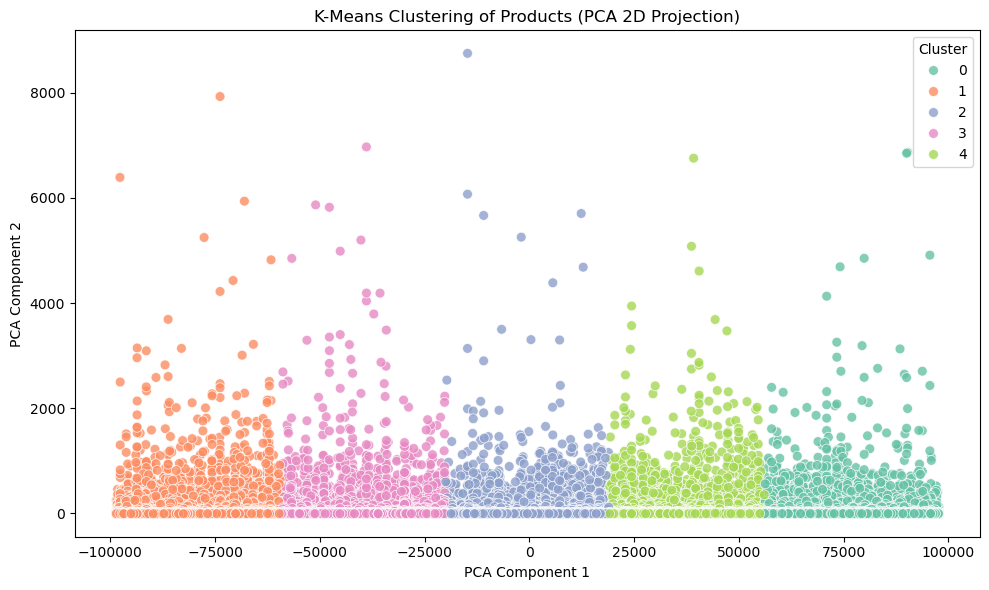

In [109]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

X = product_stats[["mean_rating", "total_reviews", "brand_id", "category_id"]]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

product_stats["pca1"] = components[:, 0]
product_stats["pca2"] = components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_stats, x="pca1", y="pca2", hue="cluster", palette="Set2", s=50, alpha=0.8)

plt.title("K-Means Clustering of Products (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from IPython.display import display

cluster_summary = product_stats.groupby("cluster").agg(
    size=("asin", "count"),
    avg_rating=("mean_rating", "mean"),
    avg_reviews=("total_reviews", "mean"),
    avg_brand=("brand_id", "mean"),
    avg_category=("category_id", "mean")
).round(2).reset_index()

print("Cluster Analysis Summary:")
display(cluster_summary)

Cluster Analysis Summary:


,cluster,size,avg_rating,avg_reviews,avg_brand,avg_category
0,0,469178,4.01,5.97,172760.37,7.57
1,1,423900,4.07,7.27,20293.44,7.56
2,2,396252,4.04,6.28,98524.85,6.63
3,3,427991,4.03,6.71,58339.93,7.63
4,4,416525,4.08,6.93,136623.65,7.84
